#Importing the Necessary Library Modules:

In [49]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import LSTM,Dense ,Dropout, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, max_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf


#Importing Lumle Data to forecast the Min/Max Temperature


In [51]:
data = pd.read_csv("CleanedFinalDateset/Airportfinaldata1.csv")
data.head()

,Date,Precipitation,Air Temperature,Relative Humidity,Wind Speed
0,2019-11-11 06:00,0.0,23.4,69.4,2.4
1,2019-11-11 07:00,0.0,24.3,64.7,2.5
2,2019-11-11 08:00,0.0,25.0,59.3,2.5
3,2019-11-11 09:00,0.0,25.4,57.5,2.4
4,2019-11-11 10:00,0.0,24.8,60.4,2.3


In [52]:
data.isnull().sum()

Date                 0
Precipitation        0
Air Temperature      0
Relative Humidity    0
Wind Speed           0
dtype: int64

In [53]:
data.describe()

,Precipitation,Air Temperature,Relative Humidity,Wind Speed
count,30051.000000,30051.000000,30051.000000,30051.000000
mean,0.464121,19.713673,83.803287,1.460531
std,2.538880,6.376164,19.684580,0.742332
min,0.000000,3.500000,30.000000,0.000000
25%,0.000000,14.600000,69.900000,0.900000
50%,0.000000,20.800000,93.700000,1.400000
75%,0.000000,24.200000,100.000000,1.900000
max,30.000000,37.200000,100.000000,8.000000


In [54]:
train_dates=pd.to_datetime(data['Date'])

# Creating the lag features, so that model will capture the periodicity

In [55]:
#mentioned lag feature  for the min temperature
for i in [1]:
    data["lag_f{}".format(i)] = data['Precipitation'].shift(i)

data['lag_f1']=data['lag_f1'].fillna(0)
# data['lag_f2']=data['lag_f2'].fillna(0)
# data['lag_f3']=data['lag_f3'].fillna(0)

# data[['Precipitation', 'lag_f1', 'lag_f2', 'lag_f3' ]]

In [56]:
data[:10]

,Date,Precipitation,Air Temperature,Relative Humidity,Wind Speed,lag_f1
0,2019-11-11 06:00,0.0,23.4,69.4,2.4,0.0
1,2019-11-11 07:00,0.0,24.3,64.7,2.5,0.0
2,2019-11-11 08:00,0.0,25.0,59.3,2.5,0.0
3,2019-11-11 09:00,0.0,25.4,57.5,2.4,0.0
4,2019-11-11 10:00,0.0,24.8,60.4,2.3,0.0
5,2019-11-11 11:00,0.0,23.3,68.4,1.7,0.0
6,2019-11-11 12:00,0.0,22.1,80.6,1.2,0.0
7,2019-11-11 13:00,0.0,21.7,80.5,1.1,0.0
8,2019-11-11 14:00,0.0,21.1,84.9,0.8,0.0
9,2019-11-11 15:00,0.0,20.0,94.9,0.6,0.0


In [57]:
# # Convert date column to datetime format
# data['Date'] = pd.to_datetime(data['Date'])

# # Create new features for day of week and month of year
# data['day_of_week'] = data['Date'].dt.dayofweek
# data['month'] = data['Date'].dt.month

# # Create sine and cosine features for day of week
# data['day_of_week_sin'] = np.sin(2*np.pi*data['day_of_week']/7)
# data['day_of_week_cos'] = np.cos(2*np.pi*data['day_of_week']/7)

# # Create sine and cosine features for month of year
# data['month_sin'] = np.sin(2*np.pi*data['month']/12)
# data['month_cos'] = np.cos(2*np.pi*data['month']/12)

In [58]:
data.to_csv('AirportHourlyPrecipitation.csv')

In [59]:
#drop the day of week and month column
# new_df = data.drop(['Date','day_of_week', 'month'], axis=1)
new_df = data.drop(['Date'], axis=1)


#Scaling the Data

In [60]:
scaler=StandardScaler()
scaler.fit(new_df)
data_scaled=scaler.transform(new_df)

In [61]:
data_scaled.dtype

dtype('float64')

# Sliding Window

In [62]:
# multi-step data preparation
from numpy import array
def split_sequence(data_scaled, n_past, n_future):
  X, y = list(), list()
  for i in range(len(data_scaled)):
# find the end of this pattern
    end_ix = i + n_past
    out_end_ix = end_ix + n_future
# check if we are beyond the sequence
    if out_end_ix > len(data_scaled):
      break
# gather input and output parts of the pattern
    seq_x, seq_y = data_scaled[i:end_ix,0:5], data_scaled[end_ix:out_end_ix,0]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)
# choose a number of time steps
n_past, n_future = 24, 2
# split into samples
X, y = split_sequence(data_scaled, n_past, n_future)

In [63]:
# Split the data into training, validation, and test sets
num_samples = X.shape[0]
training_samples = int(np.round(num_samples * 0.8))
test_samples = num_samples - training_samples

X_train = X[:training_samples,:]
y_train = y[:training_samples]

X_test = X[training_samples:,:]
y_test = y[training_samples:]

In [64]:
#shapes of training, validation and test dataset:
X_train.shape,y_train.shape, X_test.shape, y_test.shape

((24021, 24, 5), (24021, 2), (6005, 24, 5), (6005, 2))

# Building Model

In [65]:
#Building the model
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(512, input_shape=((24,5)), activation='tanh', return_sequences=True),
  tf.keras.layers.LSTM(64, activation='tanh'),
  tf.keras.layers.Dense(2)
  ])




In [66]:
  # Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.95)


  # Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 24, 512)           1060864   
                                                                 
 lstm_5 (LSTM)               (None, 64)                147712    
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 1,208,706
Trainable params: 1,208,706
Non-trainable params: 0
_________________________________________________________________


In [67]:
model_history = model.fit(X_train, y_train, batch_size=64, validation_data=(X_test,y_test), epochs=20)

Epoch 1/20
376/376 [==============================] - 212s 539ms/step - loss: 0.1468 - val_loss: 0.0848
Epoch 2/20
376/376 [==============================] - 206s 549ms/step - loss: 0.1417 - val_loss: 0.0833
Epoch 3/20
376/376 [==============================] - 201s 534ms/step - loss: 0.1387 - val_loss: 0.0805
Epoch 4/20
376/376 [==============================] - 195s 520ms/step - loss: 0.1366 - val_loss: 0.0790
Epoch 5/20
376/376 [==============================] - 199s 530ms/step - loss: 0.1350 - val_loss: 0.0780
Epoch 6/20
376/376 [==============================] - 206s 549ms/step - loss: 0.1339 - val_loss: 0.0770
Epoch 7/20
376/376 [==============================] - 203s 540ms/step - loss: 0.1329 - val_loss: 0.0769
Epoch 8/20
376/376 [==============================] - 204s 543ms/step - loss: 0.1323 - val_loss: 0.0769
Epoch 9/20
376/376 [==============================] - 196s 520ms/step - loss: 0.1316 - val_loss: 0.0765
Epoch 10/20
376/376 [==============================] - 199s 529m

# Test Data and predicted test data graph

In [68]:
#train_results

train_predictions=model.predict(X_train)
train_prediction_avg=np.mean(train_predictions, axis=1)
y_train1d=np.mean(y_train, axis=1)
train_results=pd.DataFrame(data={'Train Predictions':train_prediction_avg, 'Actuals': y_train1d})
train_results

751/751 [==============================] - 70s 91ms/step


,Train Predictions,Actuals
0,-0.178100,-0.182808
1,-0.174674,-0.182808
2,-0.156997,-0.182808
3,-0.139221,-0.182808
4,-0.129388,-0.182808
...,...,...
24016,-0.127348,-0.182808
24017,-0.168986,-0.182808
24018,-0.168698,-0.182808
24019,-0.171952,-0.182808


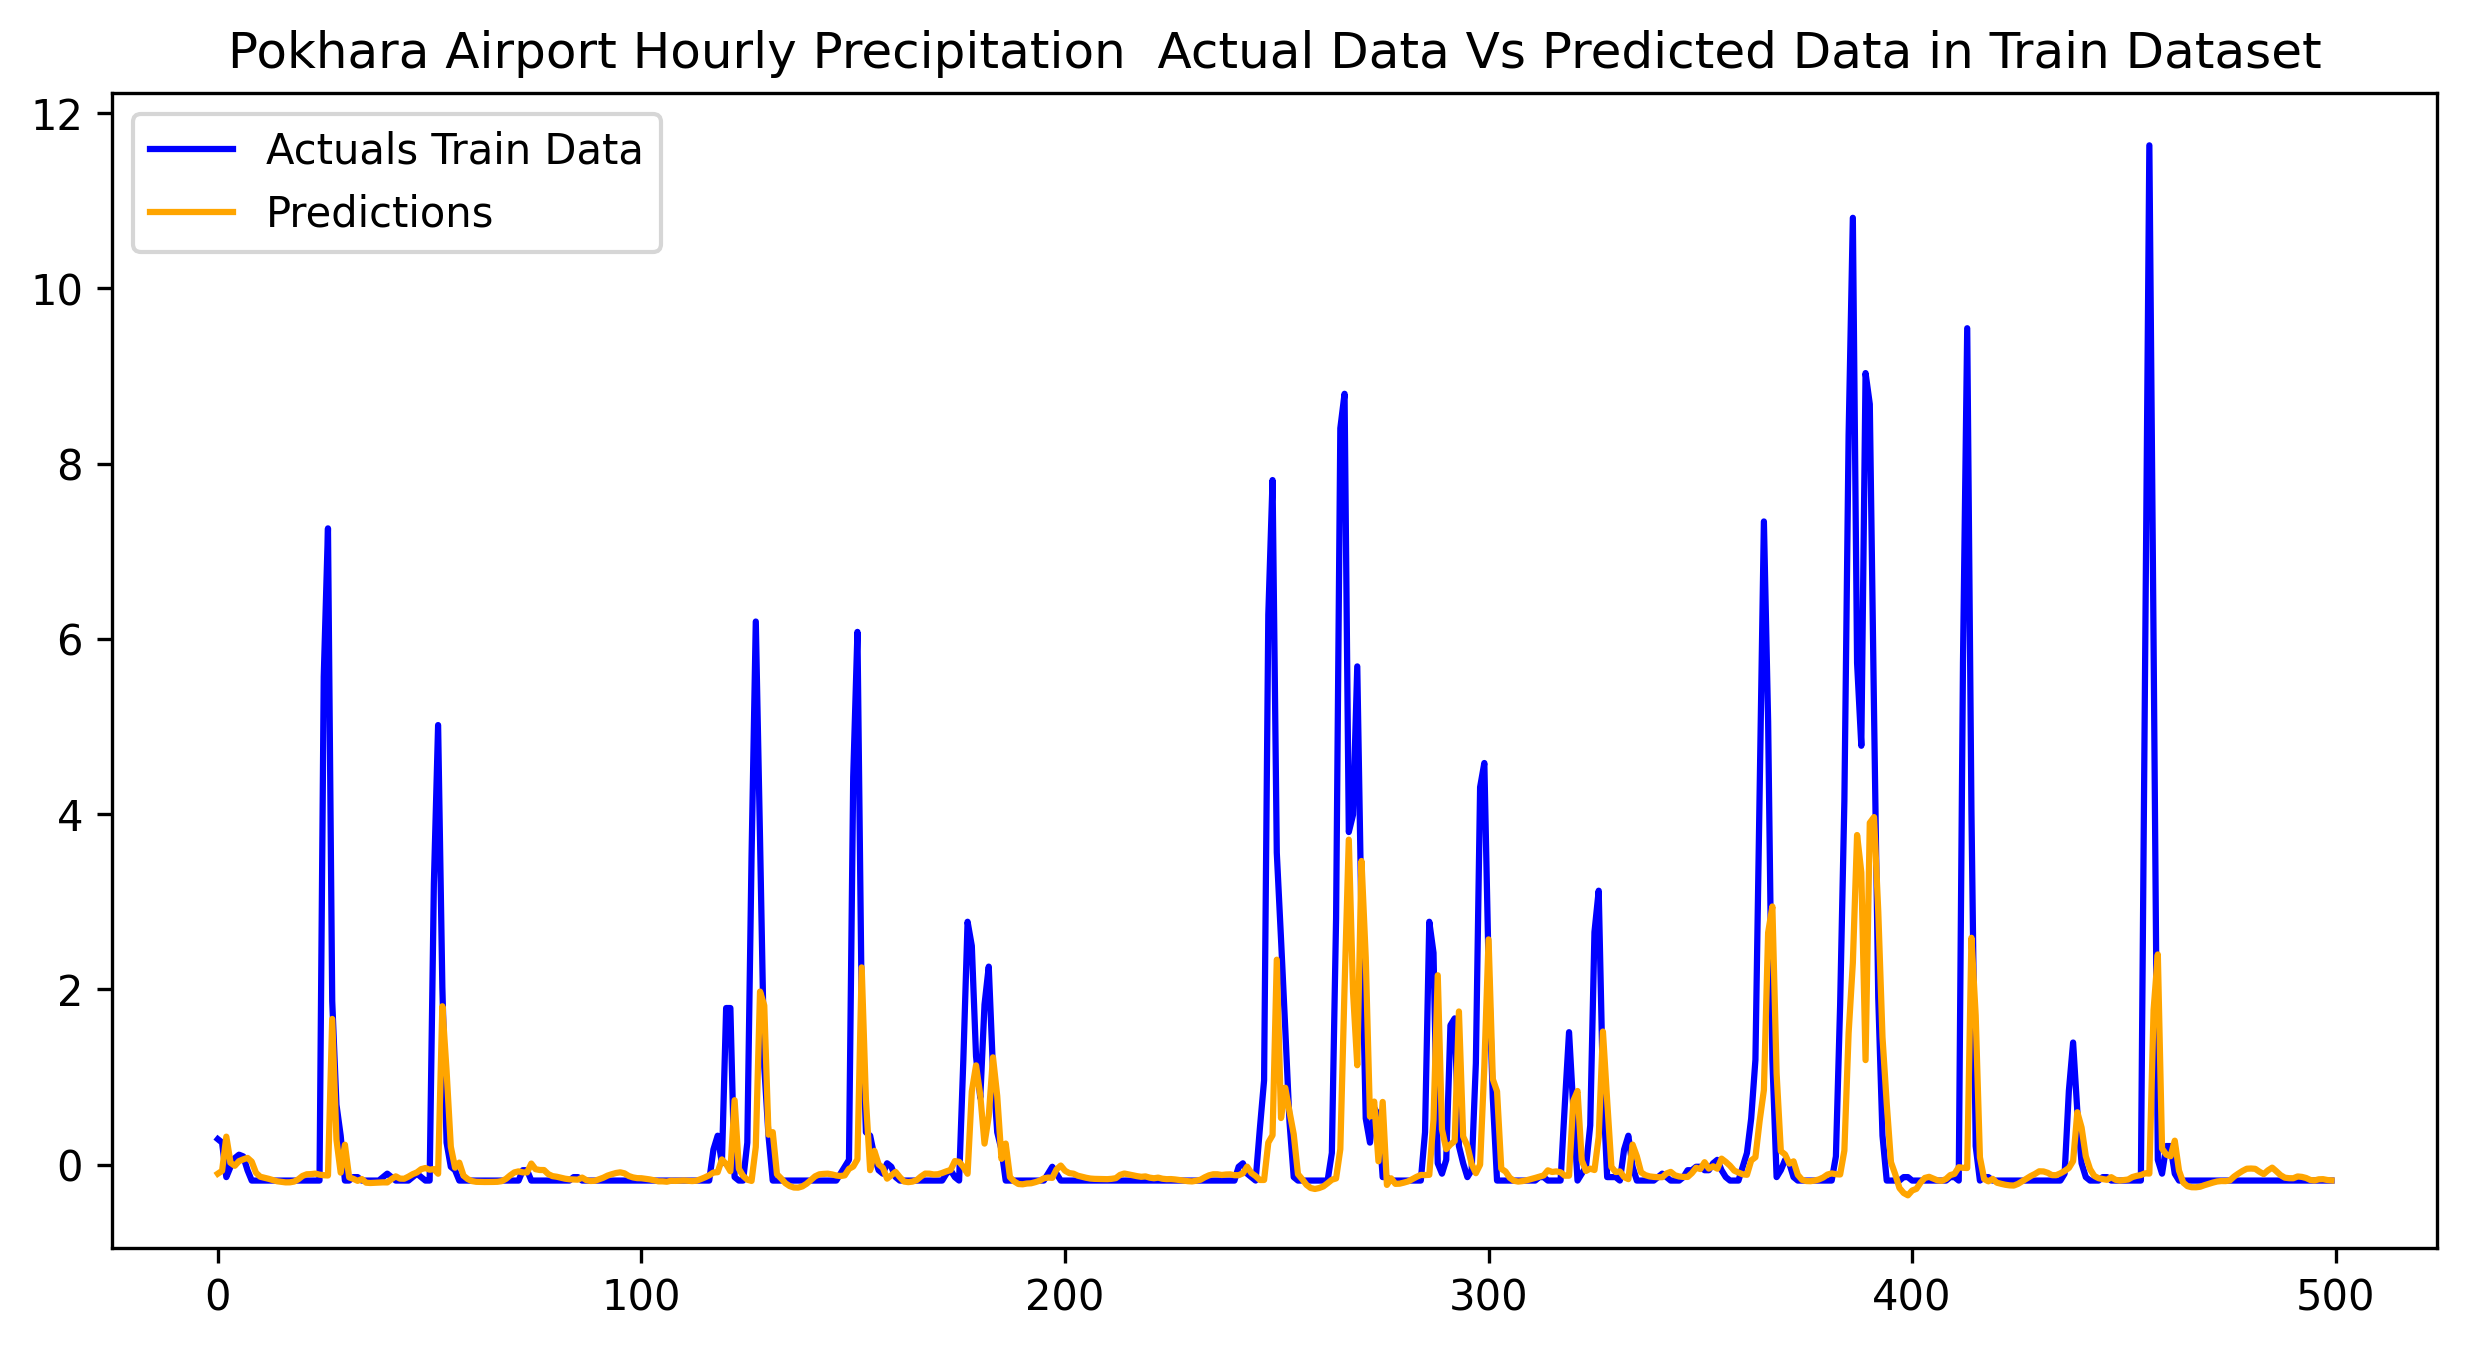

In [83]:
#plotting the training results:
plt.figure(figsize=(10,5), dpi=300)
# Create a plot
plt.plot(y_train1d[14000:14500],color='blue', linewidth=1.5, label='Actuals Train Data')
plt.plot(train_prediction_avg[14000:14500], color='orange', linewidth=1.5, label='Predictions')
plt.title('Pokhara Airport Hourly Precipitation  Actual Data Vs Predicted Data in Train Dataset')
# Add a legend
plt.legend()

# Show the plot
plt.show()


In [70]:
#Testing the Test data  accuracy
#flatten will give only the 2d into 1d  so it shifts the data to some extent of right hence to not shifting this data we calculate the 
#mean so that this will give the better visualization
#test_predictions=model1.predict(X_test).flatten()
test_predictions=model.predict(X_test)
test_prediction_avg=np.mean(test_predictions, axis=1)
y_test1d=np.mean(y_test, axis=1)
test_results=pd.DataFrame(data={'Test Predictions':test_prediction_avg, 'Actuals': y_test1d})
test_results

188/188 [==============================] - 17s 88ms/step


,Test Predictions,Actuals
0,-0.168761,-0.182808
1,-0.167854,-0.182808
2,-0.173592,-0.182808
3,-0.182546,-0.182808
4,-0.182736,-0.182808
...,...,...
6000,-0.165724,-0.182808
6001,-0.173083,-0.182808
6002,-0.204003,-0.182808
6003,-0.229084,-0.182808


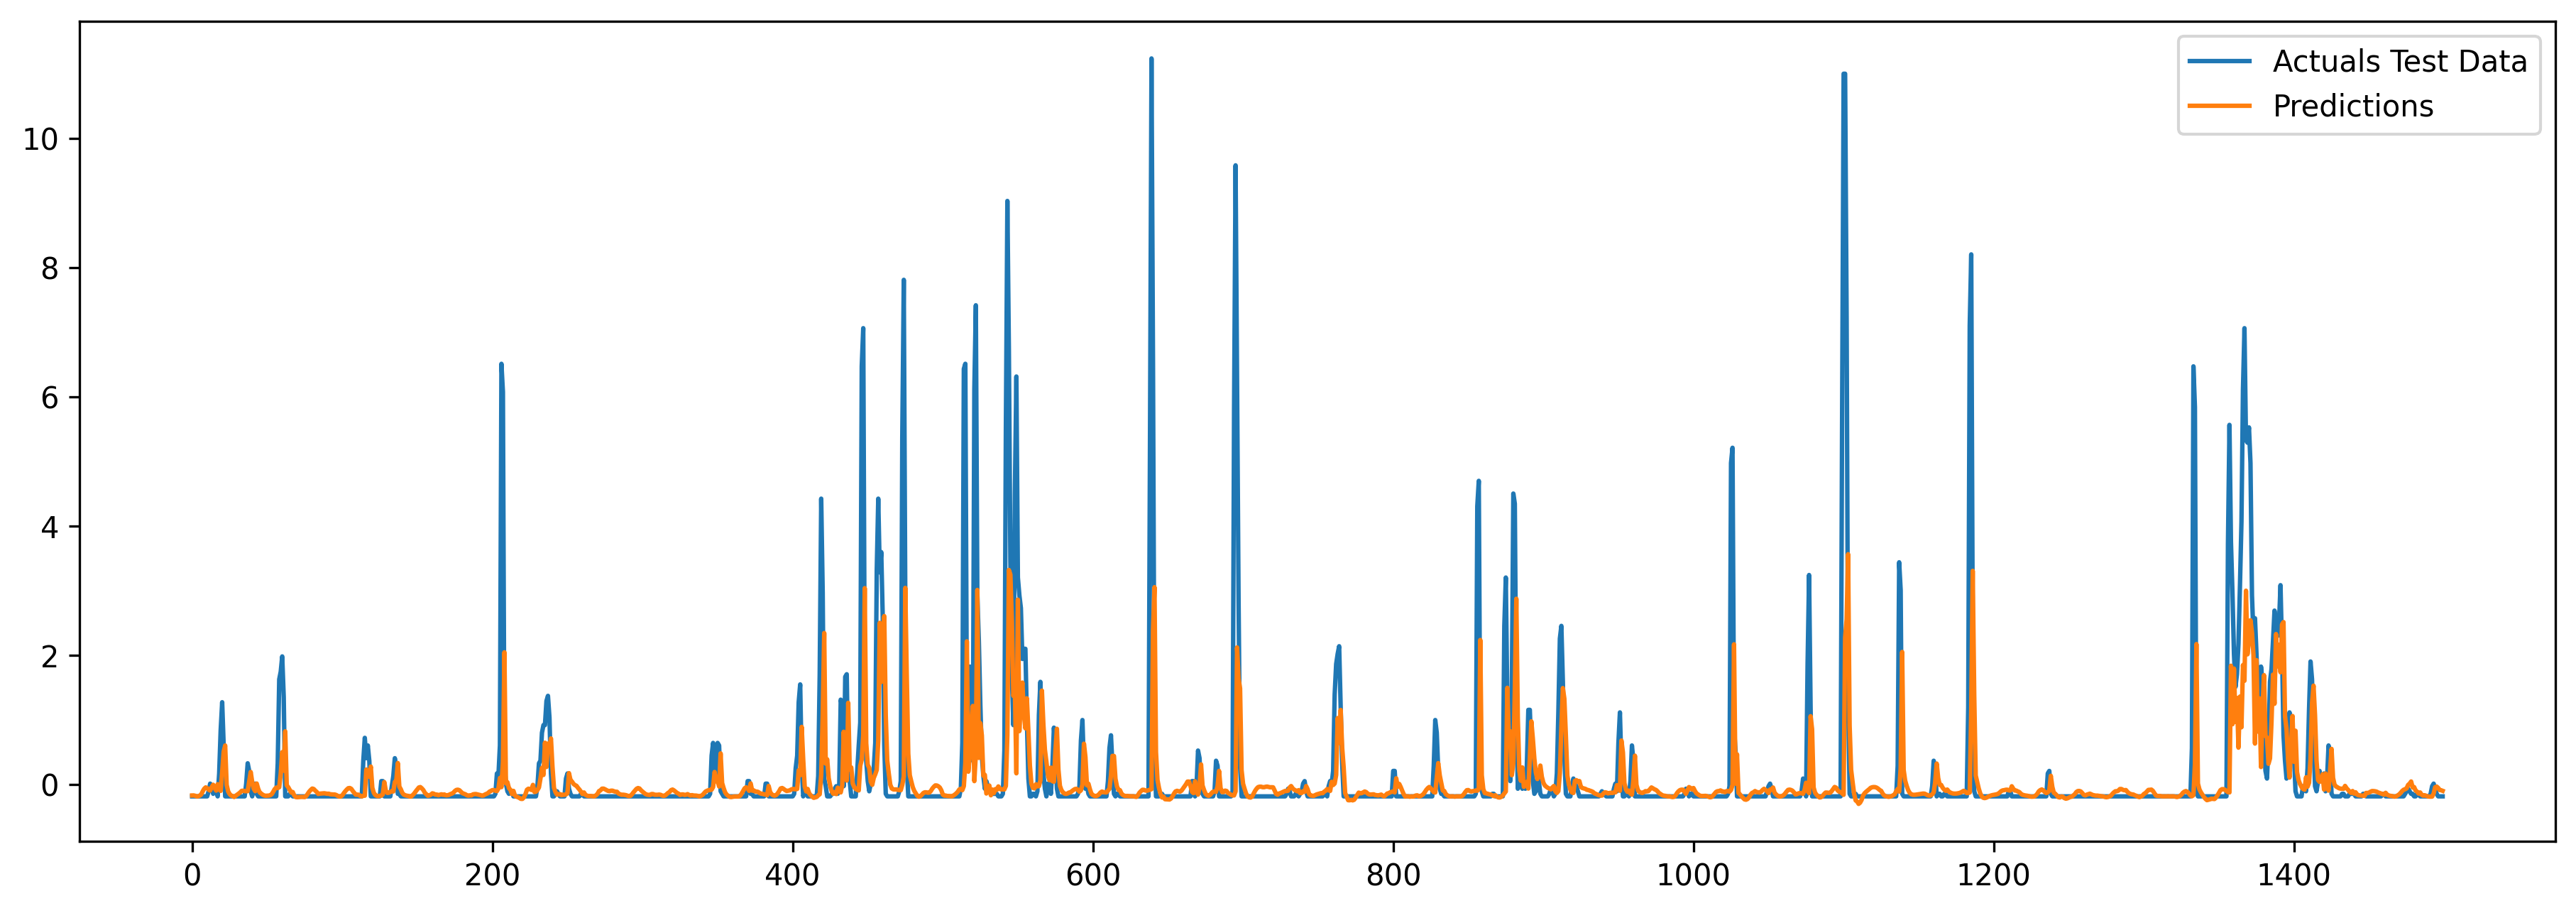

In [71]:
#plotting the testing results:
plt.figure(figsize=(15,5), dpi=300)
# Create a plot
plt.plot(y_test1d[:1500], label='Actuals Test Data')
plt.plot(test_prediction_avg[:1500], label='Predictions')

# Add a legend
plt.legend()

# Show the plot
plt.show()

# Loss in Training and Validation over the different epoches


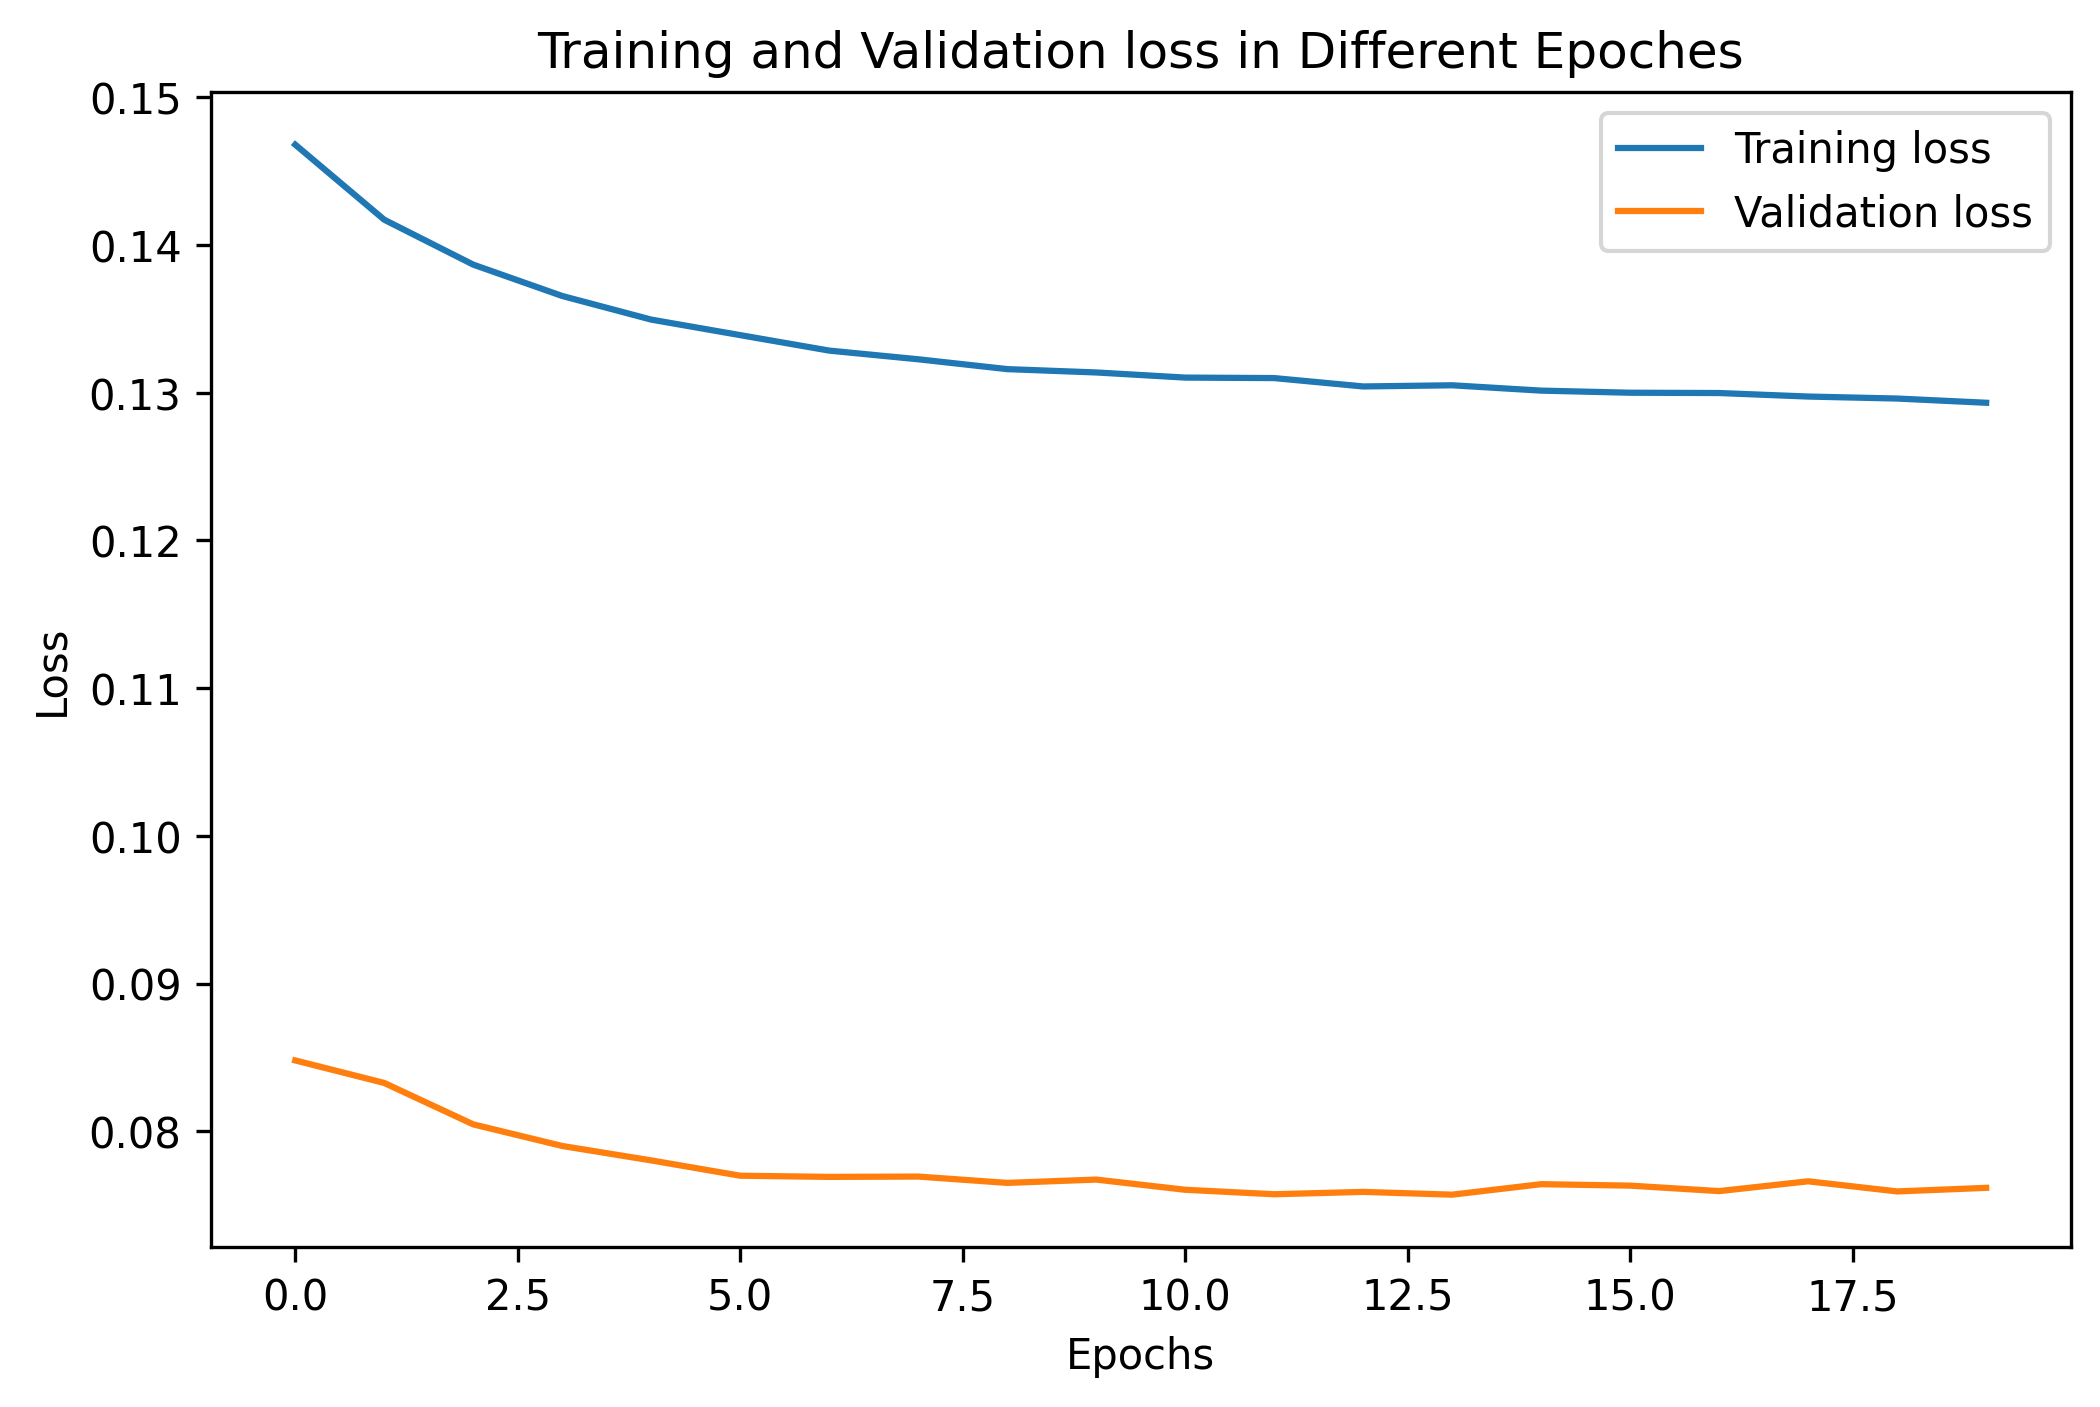

In [72]:
#to plot the loss over the training and validation epoch we can do now as 
history_df = pd.DataFrame(model_history.history)
plt.figure(figsize=(8,5), dpi=300)
plt.plot(history_df.loc[:, ['loss']], label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']], label='Validation loss')
plt.title('Training and Validation loss in Different Epoches')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

#Calculating RMSE and Accuracy of Model

In [73]:
#training
train_error =y_train1d- train_prediction_avg
squared_train_error = train_error ** 2
mean_squared_error = np.mean(squared_train_error)
rmse = np.sqrt(mean_squared_error)

print("RMSE:", rmse)

RMSE: 0.7837579932479114


In [74]:
#Testing
error = y_test1d - test_prediction_avg
squared_error = error ** 2
mean_squared_error = np.mean(squared_error)
rmse = np.sqrt(mean_squared_error)

In [75]:
from sklearn.metrics import r2_score
r2_train = r2_score(y_train1d, train_prediction_avg)
r2_train

0.2769649803785975

In [76]:
from sklearn.metrics import r2_score
r2_test = r2_score(y_test1d, test_prediction_avg)
r2_test

0.23632476898227006

# Model Saving

In [86]:
# save the model to a file in .h5 format
model.save('model/AirportHourlyPrecipitationmodel.h5')